In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, date
import numpy as np
import pytz
import matplotlib.pyplot as plt
from matplotlib import style

In [5]:
list_symbols = pd.read_excel('/Users/alexandre/Desktop/FIIs/FiisPY/Melhores_Fiis.xlsx')['Código'].values
list_symbols

array(['RZAK11', 'URPR11', 'CACR11', 'HABT11', 'VGIR11', 'SADI11',
       'RBRY11', 'TGAR11', 'VGHF11', 'HGCR11', 'KNCR11', 'MCHF11',
       'AFHI11', 'HTMX11', 'IRDM11', 'BTCI11', 'KNHY11', 'NAVT11',
       'MXRF11', 'MCCI11', 'CVBI11', 'RZAT11', 'XPCI11'], dtype=object)

In [6]:
list_melhores = []
list_relacao_mm = []
list_precos = []
for ativo in list_symbols[:1]:
    soma_fundamentos = 0
    dividend_yield = 0
    dados = yf.Ticker('HGLG11.SA')
    hist = dados.history(period='24mo',interval = '1wk')
    hist_precos = hist['Close']
    hist_dividendos = hist['Dividends']
    hist_dividendos_ultimo_ano = hist_dividendos.loc[datetime(2022,1,1, tzinfo=pytz.utc):datetime(2023,9,30, tzinfo=pytz.utc)]
    dividend_yield = (hist_dividendos_ultimo_ano.sum()/2)/hist_precos.iloc[-1] if hist_precos.iloc[-1] > 0 else 0
    if dividend_yield > 0.03:
        try:
            balanco_anual = dados.balance_sheet
            balanco_trimestral = dados.quarterly_balance_sheet
            dre_anual = dados.financials
            dfc_anual = dados.cashflow
            dre_trimestral = dados.quarterly_financials
            dfc_trimestral = dados.quarterly_cash_flow
            if dre_anual.keys()[0].year >= 0:
                balanco = balanco_anual    
                dre = dre_anual
                dfc = dfc_anual
                variacao_receita = int(dre.loc['Total Revenue'].values[0] > dre.loc['Total Revenue'].values[1])
                variacao_ebit = int(dre.loc['EBIT'].values[0] > dre.loc['EBIT'].values[1])
                variacao_caixa = int(dfc.loc['Changes In Cash'].values[0] > dfc.loc['Changes In Cash'].values[1])
                variacao_divida = int(balanco.loc['Current Liabilities'].values[0] < balanco.loc['Current Liabilities'].values[1])
                soma_fundamentos = variacao_caixa + variacao_ebit + variacao_receita + variacao_divida
                # print(soma_fundamentos)       
                if soma_fundamentos >= 2:
                    print(ativo,variacao_divida,variacao_caixa,variacao_ebit,variacao_receita,dre_anual.keys()[0])
                    list_melhores.append(ativo)
                    list_relacao_mm.append(abs(hist_precos.iloc[-1] / np.mean(hist_precos.iloc[-40:])-1))
                    list_precos.append(round(hist_precos.iloc[-1],2))
            else:
                continue
        except:
            print('Erro - ' + ativo)
            continue

Erro - RZAK11


In [4]:
carteira_df = pd.DataFrame({'MM':list_relacao_mm,'Preços':list_precos}, index=list_melhores).sort_values(by = 'MM',ascending=True)

carteira_df

,MM,Preços


In [10]:
lista_drop = []
carteira_limpa = carteira_df.drop(lista_drop)
carteira_limpa

,MM,Preços
RZAK11,0.011402,157.66


In [11]:
list_pesos = [(1+x)/(carteira_limpa['MM'].sum()+len(carteira_limpa['MM'].values)) for x in carteira_limpa['MM'].values]
list_pesos.reverse()

carteira_limpa['Pesos'] = list_pesos
carteira_limpa

,MM,Preços,Pesos
RZAK11,0.011402,157.66,1.0


In [12]:
patrimonio_inicial = 1200

carteira_limpa['Lote'] = round((carteira_limpa['Pesos'] * patrimonio_inicial/carteira_limpa['Preços'])/100,2)*100
carteira_limpa

,MM,Preços,Pesos,Lote
RZAK11,0.011402,157.66,1.0,8.0


In [13]:
carteira_final = carteira_limpa[['Lote','Preços']]
carteira_final

,Lote,Preços
RZAK11,8.0,157.66


In [14]:
# #### SEPARAR VALORES

precos_list = hist['Close'].values
datas_precos_list = hist.index

#### TRATAR DIVIDENDOS (LIMPAR OS ZEROS)
dividendos = dividendos_dif_zero = hist['Dividends'][hist['Dividends'] != 0]
dividendos

Date
2022-03-28 00:00:00-03:00    1.080226
2022-05-02 00:00:00-03:00    1.086190
2022-05-30 00:00:00-03:00    1.086190
2022-06-27 00:00:00-03:00    3.258570
2022-08-01 00:00:00-03:00    1.086190
2022-08-29 00:00:00-03:00    1.086190
2022-10-03 00:00:00-03:00    1.086190
2022-10-31 00:00:00-03:00    1.086190
2022-11-28 00:00:00-03:00    1.086190
2023-01-02 00:00:00-03:00    2.172380
2023-01-30 00:00:00-03:00    1.086190
2023-02-27 00:00:00-03:00    1.086190
2023-04-03 00:00:00-03:00    1.086190
2023-05-01 00:00:00-03:00    1.086190
2023-05-29 00:00:00-03:00    1.100000
2023-07-03 00:00:00-03:00    1.500000
2023-07-31 00:00:00-03:00    1.100000
2023-08-28 00:00:00-03:00    1.100000
2023-10-02 00:00:00-03:00    1.100000
2023-10-30 00:00:00-03:00    1.100000
Name: Dividends, dtype: float64

In [15]:
dividendos_list = dividendos.values
datas_dividendos_list = dividendos.index


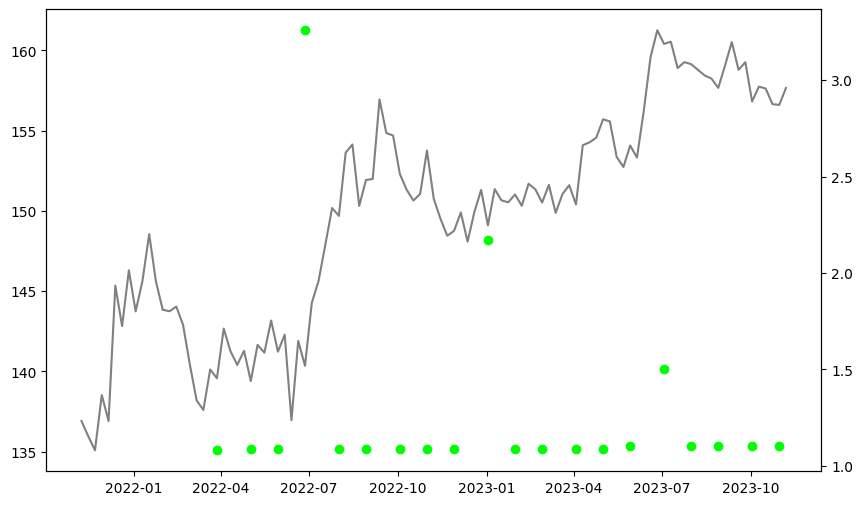

In [16]:

fig, ax1 = plt.subplots(1,1,figsize = (10,6))
ax1.plot(datas_precos_list,precos_list, color = 'grey')
ax2 = ax1.twinx()
ax2.scatter(datas_dividendos_list,dividendos_list,color = 'lime')
plt.show()

In [17]:
#### CRIAR FUNÇÃO PARA CALCULAR INDICADORES TÉCNICOS

def media_movel(lista,periodos):
    lista_indicador = []
    if len(lista) < periodos:
        print('Amostra insuficiente')
        return lista_indicador
    else:
        for i in range(periodos):
            lista_indicador.append(0)
        for j in range(len(lista)-periodos):
            indicador = np.mean(lista[j:j+periodos])
            lista_indicador.append(indicador)
        return lista_indicador

def ifr(lista,periodos):
    lista_indicador = []
    if len(lista) < periodos:
        print('Amostra insuficiente')
        return lista_indicador
    else:
        list_returns = [(lista[i] / lista[i-1])-1 for i in range(len(lista))]
        for i in range(periodos):
            lista_indicador.append(0)
        for j in range(len(list_returns)-periodos):
            positivo = np.mean([(x if x > 0 else 0) for x in list_returns[j:j+periodos]])
            negativo = np.mean([abs(x if x < 0 else 0) for x in list_returns[j:j+periodos]])
            #### IFR = (100 - (100/(1+POSITIVO/NEGATIVO)))
            indicador = (100 - (100/(1+positivo/negativo))) if negativo > 0 else 100
            lista_indicador.append(indicador)
        return lista_indicador

periodos_mm = 100
periodos_ifr = 14
print(len(precos_list))
print(len(media_movel(precos_list,periodos_mm)))   
print(len(ifr(precos_list,periodos_ifr)))

105
105
105


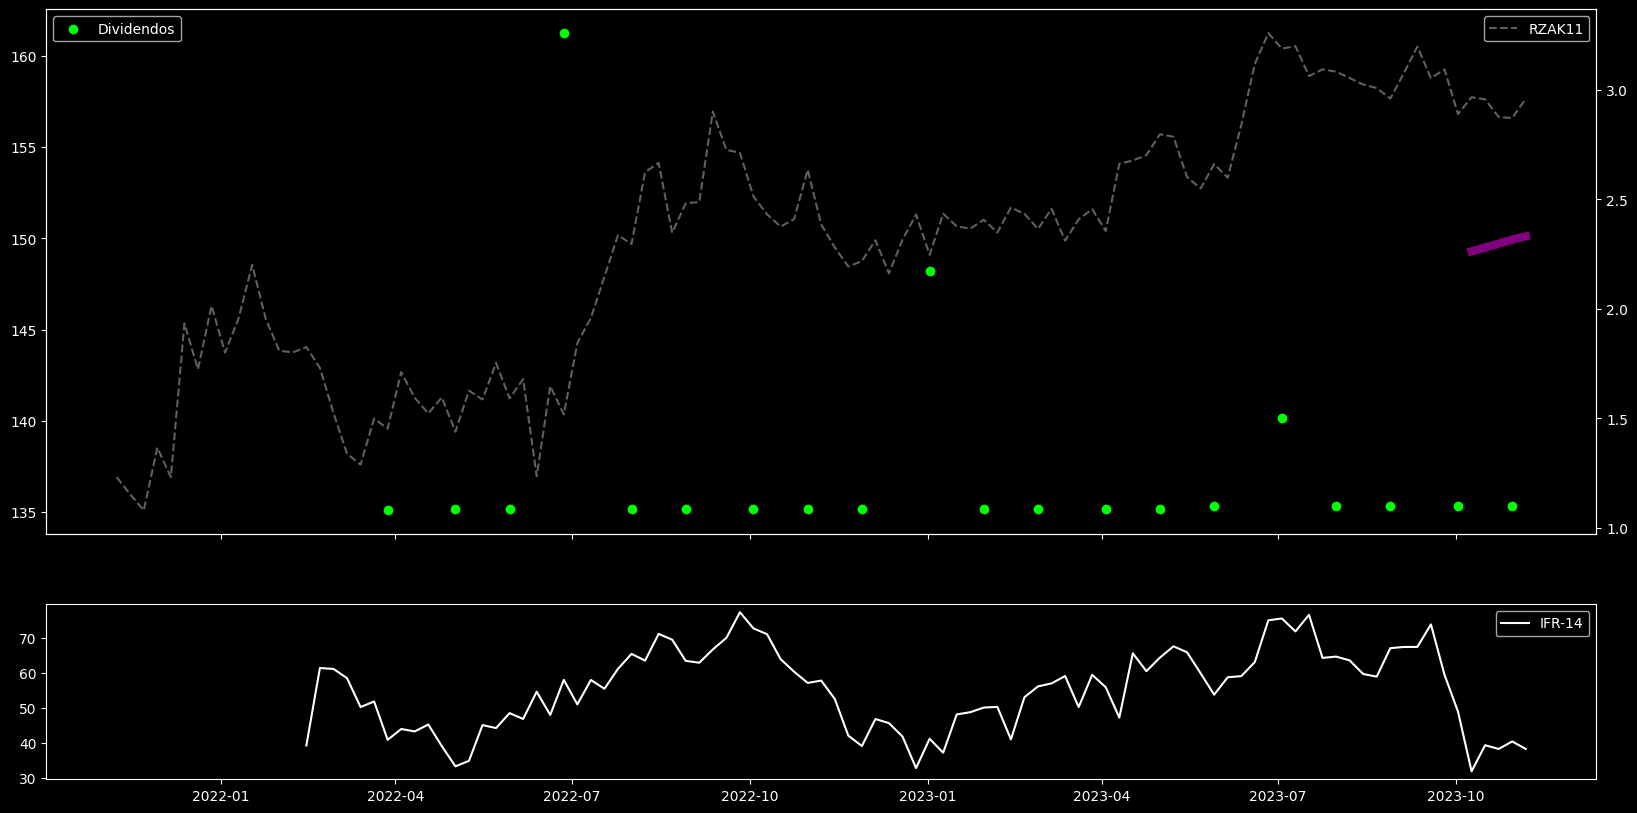

In [18]:
#### PLOTAR
style.use('dark_background')
fig1, [ax1,ax2] = plt.subplots(2,1,figsize = (20,10),gridspec_kw={'height_ratios': [3, 1]},sharex = True)
ax1.plot(datas_precos_list,precos_list, color = 'grey',linestyle = 'dashed',alpha = 0.75)
ax1.plot(datas_precos_list[periodos_mm:],media_movel(precos_list,periodos_mm)[periodos_mm:],color = 'purple',linewidth = 6)
ax2.plot(datas_precos_list[periodos_ifr:],ifr(precos_list,periodos_ifr)[periodos_ifr:],color = 'white')
ax1.legend([ativo])
ax2.legend(['IFR-{}'.format(periodos_ifr)])
ax3 = ax1.twinx()
ax3.scatter(datas_dividendos_list,dividendos_list,color = 'lime')
ax3.legend(['Dividendos'],loc='upper left')
plt.show()